# Exercise 3

Exercise 3 includes four problems that you need to solve with programming, and by providing answers to questions. For each problem you need to modify the notebook by adding your own solutions. Remember to save and commit your changes locally, and push your changes to GitHub after each major change! Regular commits will help you to keep track of your changes (and revert them if needed). Pushing your work to GitHub will ensure that you don't lose any work in case your computer crashes (can happen!).

**Due date**

This exercise should be returned to your personal Github repository within **two weeks** after the exercise was released (by **Friday 3.12 23:59**). Please notice that finishing the programming exercises can take significant amount of time (especially if you don't have yet much programming experience). Hence, **it is recommended that you start immediately working on them**.

**Start your exercise in CSC Notebooks**

Before you can start programming, you need to launch the CSC Notebook instance and clone your Exercise repository there using Git. If you need help with this, [read the documentation on the course site](https://spatial-analytics.readthedocs.io/en/latest/lessons/L1/git-basics.html).

**Hints**

If there are general questions arising from this exercise, we will add hints to the course website under [Exercise 3 description](https://spatial-analytics.readthedocs.io/en/latest/lessons/L3/exercise-3.html).

## Input data

In this exercise, we use data from an area in Northern Sweden representing **copper content of rock samples**. 

- The data is provided to you as a GeoJSON file which is located in `data/copper_data.geojson`. 
- In the data, you see three attributes `F1`, `F2` and `F3`. First two are horizontal coordinates of sample point in Swedish rectangular coordinate system. The third field `F3` is the relative copper content in soil as mg/kg (ppm). 
- The data has been obtained from the [Geological Survey of Sweden (SGU)](https://www.sgu.se/en/).


## Helper functions

The following functions are provided for you to make things easier. **You need to execute/run this cell before you can use them!**
Scroll down the notebook to find the Problems where you should use these functions for different tasks.
Hint: You might want to study these functions carefully, and especially the documentation provided for them (as docstrings) to understand how to use them.

There are altogether 6 functions below from which you will be using 5 in this exercise:

1. `create_hexagon_grid()`
2. `interpolate_idw()`
3. `get_semivariogram_model()`
4. `interpolate_ordinary_kriging()`
5. `calculate_RMSE()`

In [1]:
def create_hexagon_grid(gdf, gridsize=60):
    """
    Generates a Hexagon-grid GeoDataFrame having the same extent as the input gdf. 
    
    Parameters
    ----------
    
    gdf: gpd.GeoDataFrame with points
        
        A GeoDataFrame containing points (note: other geometry types won't work)
        
    gridsize: int 
    
        Number of hexagons that should be created per side. Default 60.
    
    """
    import geopandas as gpd
    import matplotlib.pyplot as plt
    from shapely.geometry import Polygon
    import numpy as np

    # Get coordinates
    x = gdf.geometry.x.values
    y = gdf.geometry.y.values

    # Create the hexagons
    plt.axis('off')
    collection = plt.hexbin(x,y, gridsize=gridsize, 
                           alpha=0, linewidths=0)
    
    # Parse the hexagon geometries into Shapely Polygons
    hex_polys = collection.get_paths()[0].vertices
    hex_array = []
    for xs, ys in collection.get_offsets():
        hex_x = np.add(hex_polys[:,0],  xs)
        hex_y = np.add(hex_polys[:,1],  ys)
        hex_array.append(Polygon(np.vstack([hex_x, hex_y]).T))
        
    return gpd.GeoDataFrame({'geometry': hex_array}, crs=gdf.crs)


def interpolate_idw(known_gdf, 
                    unknown_gdf, 
                    value_column, 
                    target_column="predicted_idw",
                    n_neighbors=-1,
                    power=2
                   ):
    """
    A helper function to do IDW interpolation for locations defined in 'unknown_points_gdf'.
    The values in column `value_column' of the 'known_points_gdf' are used as the basis for doing the interpolation.
    
    Parameters
    ----------
    
    known_points_gdf : gpd.GeoDataFrame
        
        GeoDataFrame containing the known values at given points (i) that are used as the basis for the interpolation.
        
    unknown_points_gdf : gpd.GeoDataFrame
        
        GeoDataFrame containing the unknown locations (x). The geometries can be either points or polygons. 
        The values for these locations will be predicted using the Inverse Distance Weighting interpolation method.
        In case Polygon geometries are passed as input, the centroid of the Polygon will be used as the precise location 
        for the prediction.
    
    value_column : str
        
        The value column in the `known_points_gdf' containing the known values (𝑤𝑖) used for prediction.
        
    target_column : str
        
        The column where the predicted value (𝑧̂) will be stored.
        
    n_neighbors : int
        
        Number of neighbors to use for weighting. By default, all neighbors are used in the prediction (i.e. value: -1)
        
    power : int
    
        The power (𝛽) that defines the distance decay function (by default: 2). Higher power value emphasize the influence of the 
        points nearest to the unknown point. A smaller power value gives more equal influence of also more distant points.
        
    """
    
    import numpy as np
    from pyinterpolate.idw import inverse_distance_weighting
    
    # Parse the pointset for the known locations (training dataset)
    known_locations = get_pointset_for_interpolation(known_gdf, value_column)

    # Create empty column for interpolated values
    unknown_gdf[target_column] = None

    # Interpolate the values with the test dataset
    for row in unknown_gdf.itertuples():
        index = row.Index
        point = np.array([row.geometry.centroid.x, row.geometry.centroid.y])
        # Do the prediction using IDW
        prediction = inverse_distance_weighting(known_locations, 
                                                point, 
                                                number_of_neighbours=n_neighbors, 
                                                power=power)
        # Assign the value to the result
        unknown_gdf.loc[index, target_column] = round(prediction, 2)
        
    return unknown_gdf


def get_semivariogram_model(gdf, 
                            value_column, 
                            search_radius, 
                            max_range,
                            weighted,
                            n_ranges):
    
    """
    A helper function to find optimal semivariogram model for given points in 'gdf'.
    The values in column `value_column' of the 'gdf' are used as the empirical basis for finding the semivariogram model.
    
    Parameters
    ----------
    
    gdf : gpd.GeoDataFrame
        
        GeoDataFrame containing the known values at given points (i) that are used for calculating the semivariance.
        
    value_column : str
        
        The value column in the `gdf' containing the known values.
        
    search_radius : int
        
        The column where the predicted value (𝑧̂) will be stored.
        
    max_range : int
        
        Number of neighbors to use for weighting. By default, all neighbors are used in the prediction (i.e. value: -1)
        
    weighted : bool
    
        Whether or not to apply weighting and provide more influence on the closer points.
    
    n_ranges : int
    
        The model optimization algorithm divides the study extent into n number of ranges 
        and tests the theoretical model output against the experimental variogram for each range.
        
    """
    
    from pyinterpolate.semivariance import calculate_semivariance, TheoreticalSemivariogram
    from pyinterpolate.kriging import Krige
    
    # Extract x, y and z values from the gdf
    known_locations = get_pointset_for_interpolation(gdf, value_column)
    
    # Empirical semivariogram (based on the known values at given locations)
    emp_semivar = calculate_semivariance(data=known_locations, step_size=search_radius, max_range=max_range)

    # Theoretical semivariogram
    semivar = TheoreticalSemivariogram(points_array=known_locations, empirical_semivariance=emp_semivar)

    # Find the optimal model
    semivar.find_optimal_model(weighted=weighted, number_of_ranges=n_ranges)
    semivar.show_semivariogram()

    # Specify the Kriging model
    return Krige(semivariogram_model=semivar, known_points=known_locations)
    


def interpolate_ordinary_kriging(gdf, model, target_col, error_col, n_neighbors=30):
    """
    A helper function to do Ordinary Kriging interpolation for locations defined in 'gdf' 
    based on given semivariogram 'model'.
    
    Parameters
    ----------
    
    gdf : gpd.GeoDataFrame
        
        GeoDataFrame containing the unknown locations. The geometries can be either points or polygons. 
        The values for these locations will be predicted using the Ordinary Kriging interpolation method.
        In case Polygon geometries are passed as input, the centroid of the Polygon will be used as the precise location 
        for the prediction.
        
    model : pyinterpolate.kriging.Krige
    
        Theoretical Semivariogram used for data interpolation. Use `get_semivariogram_model()` function to generate this model.
        
    target_col : str
        
        The column where the predicted value will be stored.
        
    error_col : str
        
        The column where the standard error will be stored.
        
    n_neighbors : int
        
        Number of neighbors to use for weighting. By default, all neighbors are used in the prediction (i.e. value: -1)
        
    """
    # Create empty column for interpolated values
    gdf[target_col] = None

    # Interpolate the values with the test dataset
    for row in gdf.itertuples():
        index = row.Index
        point = np.array([row.geometry.centroid.x, row.geometry.centroid.y])

        # Use Ordinary Kriging
        result = model.ordinary_kriging(point, 
                                        number_of_neighbours=n_neighbors, 
                                        test_anomalies=False)

        # The Kriging interpolation returns various things (as a tuple)
        # Here, we unpack the values into their own variables.
        # 'predicted' value for given location, standard 'error' for the estimate
        # 'weights' that were applied for given point 
        predicted, error, estimated_mean, weights = result

        # Assign the value to the result
        gdf.at[index, target_col] = round(predicted, 2)
        gdf.at[index, error_col] = error
    return gdf



def calculate_RMSE(gdf, validation_col="F3", prediction_col="predicted_value"):
    """
    A helper function to calculate the Root Mean Square Error (RMSE) for predicted values. 
    The predictions are compared against the known values (validation).
    
    Parameters
    ----------
    
    gdf: gpd.GeoDataFrame
        
        GeoDataFrame that should contain both the observed and predicted values.
        
    validation_col : str
        
        Column name for the observed values (i.e. the values that we know beforehand)
        
    prediction_col : str
        
        Column name for the predicted values (i.e. the values that were estimated using interpolation)
    
    """
    
    from sklearn.metrics import mean_squared_error
    return mean_squared_error(gdf[validation_col].values, gdf[prediction_col].values, squared=False)


def get_pointset_for_interpolation(gdf, value_column):
    """
    A helper function to extract a pointset (numpy arrays) for interpolation. 
    
    Parameters
    ----------
    
    gdf: gpd.GeoDataFrame 
        
        Input GeoDataFrame from which the pointset for interpolation are parsed. The x and y coordinates
        are parsed from the geometry, and the z values are parsed from the selected column.
        In case the input geometries are polygons, a centroid of the given geometry is returned.
        
    value_column : str
        
        The name of the column that contains the values (z) for the attribute of interest 
        (e.g. the amount of copper observed at given location). 
    """
    import numpy as np
    # Extract x, y coordinates and the attribute (z) values from the gdf 
    x = gdf.geometry.centroid.x.values
    y = gdf.geometry.centroid.y.values
    z = gdf[value_column].values
    return np.array([x, y, z]).T

## Problem 1 - Preparations

### Task 1.1 - Divide the data into training and test datasets (4 points)

**1. Read the data** file `data/copper_data.geojson` with geopandas into a variable called `data`(*the result will be a GeoDataFrame*).

**2. Generate an interactive map** using the [`.explore()` function](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explore.html) of geopandas, in which you should visualize the copper content in the column `"F3"`. You can use the classification scheme `quantiles` to better differentiate the patterns in the data (pass `scheme="quantiles"` parameter into the `.explore()` function). See an example map below. 

**3. Divide the data into training and test datasets** by randomly picking 75 % of the data for training and 25 % for test:
  - Store the training data into variable `train` and test data into variable `test`
  - **Hint 1**: For random sampling the 75 % of the data into variable `train`, you can use the `.sample()` method of pandas (see [docs for help](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html))
  - **Hint 2**: For selecting the remaining 25 % of the data, you should pick the rows the `data` which were **not** selected into the 75 % random sample. For doing this, you can take advantage of the index values in the `data` and `train`, and conduct an inverse selection using tilde (`~`) and `isin()` method. See [this StackOverflow answer](https://stackoverflow.com/a/44318806) for help.

**4. Genererate an interactive map** which shows the training points with red color and the test points with blue color. See an example map below.
  - **Hint:** Adding multiple layers with `.explore()` is possible as shown in the [last example on this page](https://geopandas.org/en/stable/docs/user_guide/interactive_mapping.html#Interactive-mapping). The examples on the page also shows how you can adjust different visualization parameters, such as color of the points.


![Copper content](img/copper_content.png)
*Example 1: The copper content visualized using quantiles classification (step 2 above).*

![Training and test points](img/training_and_test_points.png)

*Example 2: Randomly sampled points for training (75 %) and testing (25 %). Notice that the pattern you will see is likely different because they are picked randomly. (step 4 above)*

In [23]:
# YOUR CODE HERE

import geopandas as gpd

# 1. Read the data file data/copper_data.geojson with geopandas into a variable called data.
fp = "data/copper_data.geojson"
data = gpd.read_file(fp)

# 2. Generate an interactive map using the .explore() function of geopandas to visualize the copper content in the column "F3".
m1 = data.explore("F3", scheme="quantiles")

# 3. Divide the data into training and test datasets by randomly picking 75 % of the data for training and 25 % for test.
train = data.sample(frac=0.75)
test = data[~data.index.isin(train.index)]

# 4. Genererate an interactive map which shows the training points with red color and the test points with blue color.
m2 = train.explore(color="red")
test.explore(m=m2, color="blue")


### Task 1.2 - Generate a hexagon grid (2 points)

The hexagon grid will be used for producing continuous interpolation surface in the problems 2 and 3.

**1. Generate a hexagon grid** (as below) by using the `create_hexagon_grid()` function provided for you in the [Helper functions](#Helper-functions). **Store the result** into variable `grid`. You can use the default gridsize (i.e. 60). 
  - Hint: Read the function docstring in [Helper functions](#Helper-functions) to understand how it works.
**2. Generate an interactive map** showing the grid using `.explore()` that should look something like below:

![Hexagon grid](img/hexagon_grid.png)

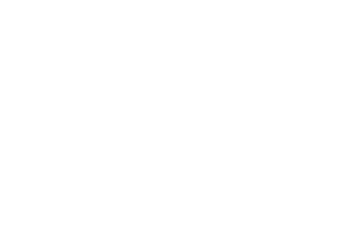

In [27]:
# YOUR CODE HERE

# 1. Generate a hexagon grid by using the create_hexagon_grid() function. 
grid = create_hexagon_grid(data, gridsize=60)

# 2. Generate an interactive map showing the grid using .explore().
grid.explore()

## Problem 2 - Interpolation with IWD

In this problem, the objective is to conduct interpolation using Inverse Distance Weighting algorithm, and test how changing the `power` influences the results and accuracy of the prediction. All the interpolations that we do in this exercise are all based on the [`pyinterpolate` -library](https://pyinterpolate.readthedocs.io/en/latest/).

### Task 2.1 - Find out the best performing $\beta$ in IDW (3 points)

**1. Use the `interpolate_idw()` function to conduct IDW interpolation** which is provided for you in [Helper functions](#Helper-functions) (read the documentation/docstring of the function for further details):

  - You should use the `train` dataset as the known data points
  - Use the `test` dataset as the points which are unknown, i.e. the predictions will be done for those locations (and saved into this table)
    - Notice that in reality, we do know the real copper values for the points in `test` but here we "pretend" that we don't know them, because in this way we can assess the accuracy of our prediction.
  - The column `"F3"` in the `train` dataset contains the values (copper content) that we want to use in prediction
  - Use **a power of 1** in the interpolation (i.e. $\beta$)
  - Specify that you want to store the result in a **column called `"idw_power_1"`**
  - Store the result from this function into a variable `test` (i.e. the `test` dataset that was passed as one of the argument will be updated)
    
**2. Calculate the Root Mean Square Error (RMSE) for the prediction** using the `calculate_RMSE()` -function that is provided for you in [Helper functions](#Helper-functions) (read the documentation/docstring of the function for further details how to use it):

  - Pass the result from step 1 (i.e. should be the variable `test`)
  - Use the `"F3"` column for the validation
  - Use the column `"idw_power_1"` as the `prediction_col`
  - Store the result into a new variable called `idw_p1`
  - Print out the RMSE for the interpolation showing how well the predicted values compare against the known values. The lower the RMSE, the better the prediction.
  
**3. Repeat the steps 1 and 2** and test how **changing the power** ($\beta$) influences the accuracy of the result. 

  - Repeat the analysis with **power values: 2,3 and 4**. Store the results into variables `idw_p2`, `idw_p3` and `idw_p4` accordingly. 
  - Which $\beta$ produces the **best** result?
  - Which $\beta$ produces the **worst** result? Why do you think it performs poorly?


In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

### Task 2.2 - Create a map with IDW predictions (2 points)

Use the power that had the best performance in the previous step, and create a map using the hexagon grid created in Task 1.2.

**1. Use the `interpolate_idw()` function** and:
  
  - use the `train` dataset as the known locations
  - use the hexagon `grid` as the unknown locations to which we will predict values using IDW
  - use the $\beta$ that performed best
  - use again the `"F3"` as the column for known values
  - specify that the results should be stored into column `idw_power_X`, where you should replace the `X` with the power that you choose to use
  - store the result from the function into variable `grid` (i.e. we will update the hexagon grid created earlier)
  
**2. Create a map with the hexagon grid** where the color of the cell should be the interpolated value from step 1. Use a colormap `"Reds"` that you can define with parameter `cmap`. If you want, you can add the `test` points on top of this hexagon grid which allows you to easily evaluate visually how well the predictions have worked at different locations. As a result, you should get something like the map below.

  - **Hint:** Adding multiple layers with `.explore()` is possible as shown in the [last example on this page](https://geopandas.org/en/stable/docs/user_guide/interactive_mapping.html#Interactive-mapping). The examples on the page also shows how you can adjust different visualization parameters, such as color of the points.
  
![IDW interpolation](img/idw_interpolation.png)

*Example map how the result from IDW interpolation should look like (approximately).*

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Problem 3 - Interpolation with Kriging

In this problem, we will continue working with the same data and use **Ordinary Kriging** to predict the values (copper content) for unknown locations.
To do this, we will:

1. Check whether the data is normally distributed. If not:
2. Transform the data by taking a log of the values, which helps to "normalize" the data
3. Find the optimal semivariogram model for the data, and test how changing the parameters influence the model fit
4. Conduct Ordinary Kriging for the `test` dataset with the selected model and validate the result by calculating the RMSE 
5. Visualize the interpolation result as well as the standard errors that shows where the prediction works well and where not

### Task 3.1 - Testing the assumptions (2 points)

**1. Is the data normally distributed?**:

  - Plot a histogram of the `"F3"` values using the `.plot.hist()` function of pandas ([see docs](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.hist.html) for help). Use 30 bins which helps showing the differences at different value classes. 
  - To make a better visual assessment of the normality, also make a [Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) that helps to estimate whether your data points follow normal distribution. For this, you can use the [`qqplot()` -function](https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.ProbPlot.qqplot.html) from the `statsmodels` library. See [this StackOverflow answer](https://stackoverflow.com/a/50677734) for reference.
  - Based on these plots, do you think the data follows normal distribution? Justify your answer.
    - Your answer:

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

**2. Log transform the data** (if it does not follow normal distribution):

In case your data was not normally distributed, it needs to be transformed in such a way that it follows normal distribution. There are a few different approaches for doing this, and one of the most common approaches is to log-transform your data which helps to make the data as "normal" as possible. (*However, note that log-transform is not always recommended e.g. [with count data having zeros](https://besjournals.onlinelibrary.wiley.com/doi/10.1111/j.2041-210X.2010.00021.x)*).

  - You can log-transform you data by using the  [`np.log()` -function](https://numpy.org/doc/stable/reference/generated/numpy.log.html) and applying it for the `"F3"` column. 
  - Store the data into a new column called `"log_F3"`
  - Test with Q-Q plot and histogram whether the data now follows better the normal distribution.

In [ ]:
# Add your code here IF NEEDED

# YOUR CODE HERE
raise NotImplementedError()

## Task 3.2 - Find optimal semivariogram model (2 points)

As a good background information for this task, I recommend to check [here a good explanation](https://pyinterpolate.readthedocs.io/en/latest/algorithms_documentation/Automatic%20Fitting%20of%20the%20Semivariogram%20Model.html) of how the optimal model can be found using the `pyinterpolate` library. Also it is **highly recommended** that you check the [slides for geostatistics](https://spatial-analytics.readthedocs.io/en/latest/lessons/L2/geostatistics-kriging.html) and [watch the lesson video](https://spatial-analytics.readthedocs.io/en/latest/lessons/L2/overview.html#lesson-videos), in case you want to revise what was said about the things relating to the questions below.

**1. Investigate your data** using the interactive maps done in earlier tasks, and update the variables (also just test how changing the values influences the result!):
    
  - Think what would be a good **search radius** for the data? The search radius defines the distance between lags within each points are included in the calculations. 
    - **Modify the value for the `search_radius` variable below** (should be in meters). **Describe why/how did you end up selecting the given value?**
    - Your answer:
  
  - Investigate the interactive maps, and think what would be the maximum possible distance between two points in the dataset? 
    - **Update the `max_range` variable** below based on your findings (should be in meters).
    - Hint: take advantage of the scalebar on the bottom left corner of the interactive maps. It updates when you zoom in/out. 
  
  - Think, whether the influence of the nearest points for given location should be **weighted or not**? 
  
    - **Update the `weighted` variable** below to `False` or `True` based on your thinking. Describe why did end up in your decision:
    - Your answer:

**2. Get the optimal semivariogram model** based on your parameters defined in step 1:

   - **Use the `get_semivariogram_model()`** provided for you in the [Helper functions](#Helper-functions) (read the documentation/docstring of the function for further details how to use it).
   - Use the `train` dataset again as the input gdf
   - Use the `"F3"` or `"log_F3"` attribute as value column, depending on whether you transformed the data or not
   - Pass the `search_radius`, `max_range`, `weighted` and `number_of_ranges` variables for the function (check the function docstring to know how the parameters are called)
   - Save the resulting model that is returned by the `get_semivariogram_model()` into a variable `model`
   
**This model is used for determining the weights for the interpolation**, and in practice used for doing the interpolation (see next step).    

As a result of this, you should end up having something like following (it can look different due to different parameter values, and it's okay):
![Semivariogram model](img/semivariogram_model.png)

In [ ]:
# Search radius (in meters in this case because our points are in metric system)
search_radius = 0

# The maximum distance between points
max_range = 0

# Weighting according to lags (True/False)
weighted = "ADD TRUE OR FALSE"

# Algorithm divides the study extent into n number of ranges and tests 
# the theoretical model output against the experimental variogram for each range
# Note: This can be as it is.
number_of_ranges = 20

# YOUR CODE HERE
raise NotImplementedError()

## Task 3.3 - Interpolate with Ordinary Kriging (2 points)

After you have defined and created a semivariogram model in the previous step, we can do the interpolation.

**1. Use the `interpolate_ordinary_kriging()` -function** provided for you in the [Helper functions](#Helper-functions) (read the documentation/docstring of the function for further details how to use it).

  - Use the `test` dataset as the gdf for the function (i.e. the predictions will be done again for those points)
  - Use the semivariogram `model` created in the previous step representing the Theoretical Semivariogram used for data interpolation.
  - Give an intuitive name for the column where the predicted values will be stored, such as `"predicted_krige"` or `"predicted_krige_log"`
  - Give an intuitive name for the column where the standard error of the predictions will be stored, such as `"std_error"` or `"std_error_log"`
  - Store the result that is returned from the `interpolate_ordinary_kriging()` into the variable `test` (i.e. we will again update that GeoDataFrame with new columns)
  
**2.** In case you have transformed the data, **back-transform the interpolation predictions and standard errors** by calculating the exponential of all predicted and standard error values:

  - Store the back-transformed values into `test` dataset with intuitive column names, such as `predicted_krige` and `std_error`
  - You can calculate the exponential by using the [`np.exp()` -function](https://numpy.org/doc/stable/reference/generated/numpy.exp.html)
  - After this step, your predicted values are on the same scale as the original values in `"F3"` column.
  
**3. What is the RMSE for the Kriging predictions?**

  - Calculate the Root Mean Square Error (RMSE) for the prediction** using the `calculate_RMSE()` -function that is provided for you in [Helper functions](#Helper-functions) (read the documentation/docstring of the function for further details how to use it):

  - Pass the `test` GeoDataFrame as the gdf
  - Use the `"F3"` column for the validation
  - Use the `"predicted_krige"` column as the `prediction_col` (i.e. the column having the values on the same scale as `"F3"`)
  - Store the result into a new variable called `krige_rmse`
  - Print out the RMSE for the interpolation showing how well the predicted values compare against the known values. The lower the RMSE, the better the prediction. 
  - Question: Did the Kriging interpolation perform better than IDW? Justify your answer with a short description.
    - Your answer: 

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

### Task 3.4 - Create a map with Ordinary Kriging predictions (2 points)

**1. Use the `interpolate_ordinary_kriging()` function** and:
  
  - use the hexagon `grid` as the unknown locations to which we will predict values using IDW
  - Use the semivariogram `model` created in the previous step representing the Theoretical Semivariogram used for data interpolation.
  - Give an intuitive name for the column where the predicted values will be stored, such as `"predicted_krige"` or `"predicted_krige_log"`
  - Give an intuitive name for the column where the standard error of the predictions will be stored, such as `"std_error"` or `"std_error_log"`
  - Store the result from the function into variable `grid` (i.e. we will update the hexagon grid created earlier)
  - If needed, back-transform the values again in a similar manner as in Task 3.3.
  
**2. Create a map with the predicted values using the hexagon grid**, where the color of the cell should be the predicted values from step 1. Use a colormap `"Reds"` that you can define with parameter `cmap`. If you want, you can again add the `test` points on top of this hexagon grid which allows you to easily evaluate visually how well the predictions have worked at different locations. As a result, you should get something like the map below.

  - **Hint:** Adding multiple layers with `.explore()` is possible as shown in the [last example on this page](https://geopandas.org/en/stable/docs/user_guide/interactive_mapping.html#Interactive-mapping). The examples on the page also shows how you can adjust different visualization parameters, such as color of the points.
  
  - **Question**: Do you think the result differs significantly from the IDW interpolation? Give a short explanation.

**3. Create a map with the standard error values using the hexagon grid**, where the color of the cell should be the standard error values. Use a colormap `"Blues"` that you can define with parameter `cmap`. As a result, you should get something like the map below.

  - **Question 1 \***: Do you see any evident patterns in the standard errors? Give a short explanation. 
    - Your answer:
  - **Question 2:** What is the purpose of Std Error map? Why is it useful?
    - Your answer:
  
\*_Further info related to Question 1: Clusters or trends in the standard errors would indicate that it would be good to try to remove the trends and consider anisotropy in the interpolation process. We won't be considering these things in this exercise, but if you are interested to learn more and take into account anisotropy there is another Python package called [PyKrige](https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/index.html) that [can handle anisotropy](https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/generated/pykrige.ok.OrdinaryKriging.html). The library also provides [Universal Kriging](https://geostat-framework.readthedocs.io/projects/pykrige/en/stable/generated/pykrige.uk.UniversalKriging.html) method allowing to use drift terms._ 

![Ordinary Kriging predictions example](img/ordinary_kriging_predictions.png)

___Example 1__ of the resulting map for the Ordinary Kriging predicted values._


![Ordinary Kriging std errors example](img/ordinary_kriging_std_errors.png)

___Example 2__ of the resulting map for the Ordinary Kriging standard error values._


In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Problem 4 - How long did it take? Optional feedback (1 point)

To help developing the exercises, and understanding the time that it took for you to finish the Exercise, please provide an estimate of how many hours you spent for doing this exercise?

 - I spent approximately this many hours: **X hours**
 
In addition, if you would like to give any feedback about the exercise (optional), please provide it below:

 - My feedback: